### 1 - Importações e Configurações Iniciais

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

### 2 - Definição do Ambiente Simulado (Pools, Regras, Custos, Pesos)

In [10]:
# Definindo os pools de conteúdo e regras condicionais para o estado "antes"
POOLS_ANTES = {
    'inimigos': {
        'Nenhum':       {'custo': 0, 'peso': 30, 'tags': []},
        'Inimigo Comum':{'custo': 10, 'peso': 100, 'tags': ['Comum']},
        'Inimigo Chefe':{'custo': 12, 'peso': 40, 'tags': ['Chefe']},
        'Inimigo Elite':{'custo': 15, 'peso': 30, 'tags': ['Elite']}
    },
    'eventos': {
        'Nenhum':       {'custo': 0, 'peso': 80, 'tags': []},
        'Tesouro':      {'custo': -5, 'peso': 40, 'tags': ['Recompensa']},
        'Armadilha':    {'custo': 8, 'peso': 30, 'tags': ['Perigo']}
    },
    'efeitos': {
        'Nenhum':         {'custo': 0, 'peso': 100, 'tags': []},
        'Terreno Lento':  {'custo': 5, 'peso': 20, 'tags': ['Terreno', 'Debuff']},
        'Zona de Evasão': {'custo': -4, 'peso': 15, 'tags': ['Buff']}
    }
}

REGRAS_CONDICIONAIS_ANTES = [
    # Se o inimigo for Elite, aumenta a chance de Terreno Lento
    {'se_tag': 'Elite', 'entao_tag': 'Terreno', 'multiplicador': 3.0}
]


# Definindo os pools de conteúdo e regras condicionais para o estado "depois"
import copy
POOLS_DEPOIS = copy.deepcopy(POOLS_ANTES)
POOLS_DEPOIS['inimigos']['Golem de Lava'] = {'custo': 25, 'peso': 15, 'tags': ['Elite', 'Térmico']}
POOLS_DEPOIS['efeitos']['Calor Radiante'] = {'custo': 7, 'peso': 10, 'tags': ['Terreno', 'Térmico']}

REGRAS_CONDICIONAIS_DEPOIS = copy.deepcopy(REGRAS_CONDICIONAIS_ANTES)
# Nova regra de sinergia para o conteúdo adicionado
REGRAS_CONDICIONAIS_DEPOIS.append(
    {'se_tag': 'Térmico', 'entao_tag': 'Terreno', 'multiplicador': 5.0}
)

### 3 - Implementação da função Gamma

In [11]:
def sortear_item(pool, orçamento_atual, contexto_tags, regras):
    itens_validos = []
    pesos_ajustados = []

    for nome, atributos in pool.items():
        if atributos['custo'] <= orçamento_atual:
            peso_final = atributos['peso']
            # Aplica regras condicionais
            for regra in regras:
                if regra['se_tag'] in contexto_tags and regra['entao_tag'] in atributos['tags']:
                    peso_final *= regra['multiplicador']
            
            itens_validos.append(nome)
            pesos_ajustados.append(peso_final)

    if not itens_validos:
        return 'Nenhum', pool['Nenhum']

    # Normaliza os pesos para criar uma distribuição de probabilidade
    soma_pesos = sum(pesos_ajustados)
    probabilidades = [p / soma_pesos for p in pesos_ajustados]

    # Sorteia um item com base nos pesos ajustados
    escolha = np.random.choice(itens_validos, p=probabilidades)
    return escolha, pool[escolha]


def gerar_conteudo_da_sala(k, T, pools, regras):
    # Orçamento inicial aumenta com a profundidade k
    orçamento_inicial = 10 + k * 2.5
    
    contexto_tags = set()
    resultado = {}

    # 1. Sorteia Inimigo
    nome_inimigo, inimigo = sortear_item(pools['inimigos'], orçamento_inicial, contexto_tags, regras)
    resultado['inimigo'] = nome_inimigo
    contexto_tags.update(inimigo['tags'])
    orçamento_restante_1 = orçamento_inicial - inimigo['custo']

    # 2. Sorteia Evento
    nome_evento, evento = sortear_item(pools['eventos'], orçamento_restante_1, contexto_tags, regras)
    resultado['evento'] = nome_evento
    contexto_tags.update(evento['tags'])
    orçamento_restante_2 = orçamento_restante_1 - evento['custo']

    # 3. Sorteia Efeito
    nome_efeito, efeito = sortear_item(pools['efeitos'], orçamento_restante_2, contexto_tags, regras)
    resultado['efeito'] = nome_efeito
    
    resultado['custo_total'] = (inimigo['custo'] + evento['custo'] + efeito['custo'])
    return resultado

### 4 - Implementação da função de Simulação

In [12]:
def simular_geracao(pools, regras, n_simulacoes=10000):
    dados = []
    for k_sim in range(1, 11):
        for _ in range(n_simulacoes // 10):
            sala = gerar_conteudo_da_sala(k=k_sim, T='padrão', pools=pools, regras=regras)
            sala['k'] = k_sim
            dados.append(sala)
    return pd.DataFrame(dados)

### 5 - Simulação com antes e depois da nova adição

In [13]:
print("Iniciando simulações...")
df_antes = simular_geracao(POOLS_ANTES, REGRAS_CONDICIONAIS_ANTES)
print("Simulação 'ANTES' concluída.")
df_depois = simular_geracao(POOLS_DEPOIS, REGRAS_CONDICIONAIS_DEPOIS)
print("Simulação 'DEPOIS' concluída.")

Iniciando simulações...
Simulação 'ANTES' concluída.
Simulação 'DEPOIS' concluída.


### 6 - Funções de Análise e Visualização

In [14]:
def analisar_frequencia(df_antes, df_depois, coluna):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    df_antes[coluna].value_counts(normalize=True).plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribuição de Frequência (ANTES) - {coluna}')
    axes[0].set_ylabel('Frequência Relativa')
    
    df_depois[coluna].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title(f'Distribuição de Frequência (DEPOIS) - {coluna}')
    
    plt.suptitle(f'Análise de Frequência para a Categoria: {coluna.upper()}', fontsize=16)
    plt.show()

def analisar_custo(df_antes, df_depois):
    plt.figure(figsize=(12, 7))
    sns.kdeplot(df_antes['custo_total'], label='ANTES', color='skyblue', fill=True)
    sns.kdeplot(df_depois['custo_total'], label='DEPOIS', color='salmon', fill=True)
    plt.title('Distribuição do Custo Total por Sala (Dificuldade)')
    plt.xlabel('Custo Total')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

def analisar_coocorrencia(df, titulo):
    cooc = pd.crosstab(df['inimigo'], df['efeito'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooc, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Matriz de Coocorrência Inimigo x Efeito ({titulo})')
    plt.show()

def calcular_metricas_info(df, col1, col2):
    # Entropia Marginal H(X)
    p_x = df[col1].value_counts(normalize=True)
    h_x = entropy(p_x, base=2)

    # Entropia Marginal H(Y)
    p_y = df[col2].value_counts(normalize=True)
    h_y = entropy(p_y, base=2)

    # Entropia Conjunta H(X, Y)
    p_xy = df.groupby([col1, col2]).size() / len(df)
    h_xy = entropy(p_xy, base=2)

    # Informação Mútua I(X; Y) = H(X) + H(Y) - H(X,Y)
    i_xy = h_x + h_y - h_xy

    return {'H(col1)': h_x, 'H(col2)': h_y, 'H(col1,col2)': h_xy, 'I(col1;col2)': i_xy}

### 7 - Análise da função geradora após adição

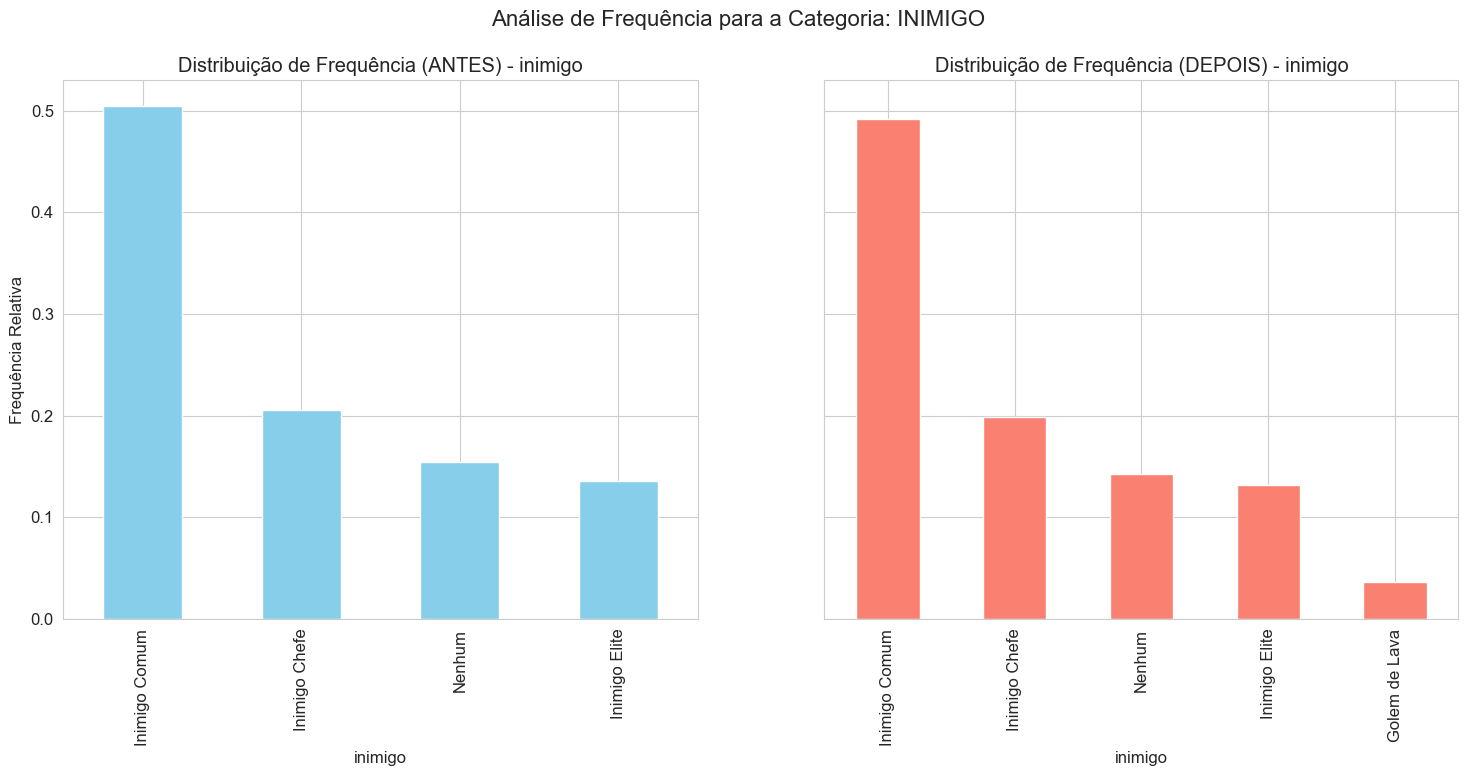

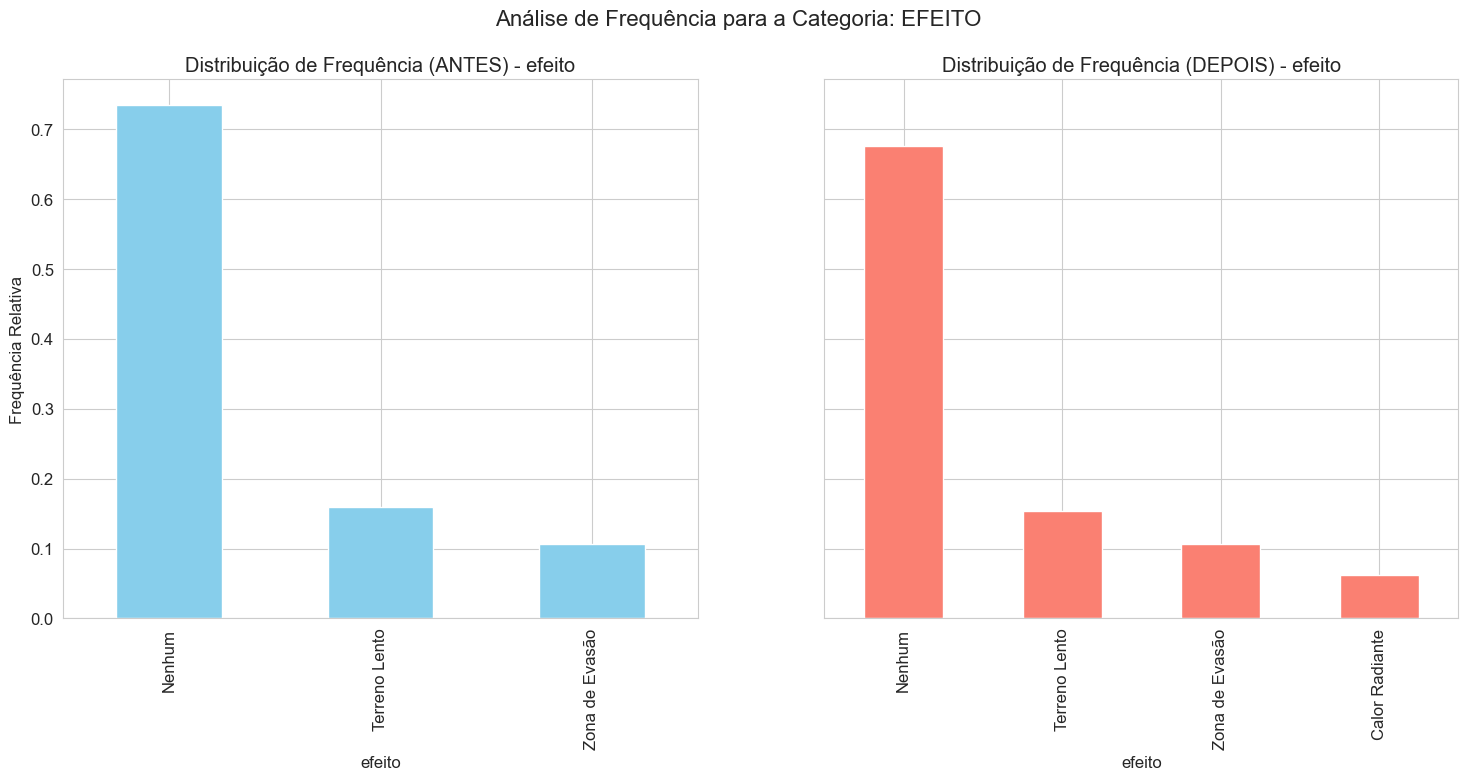

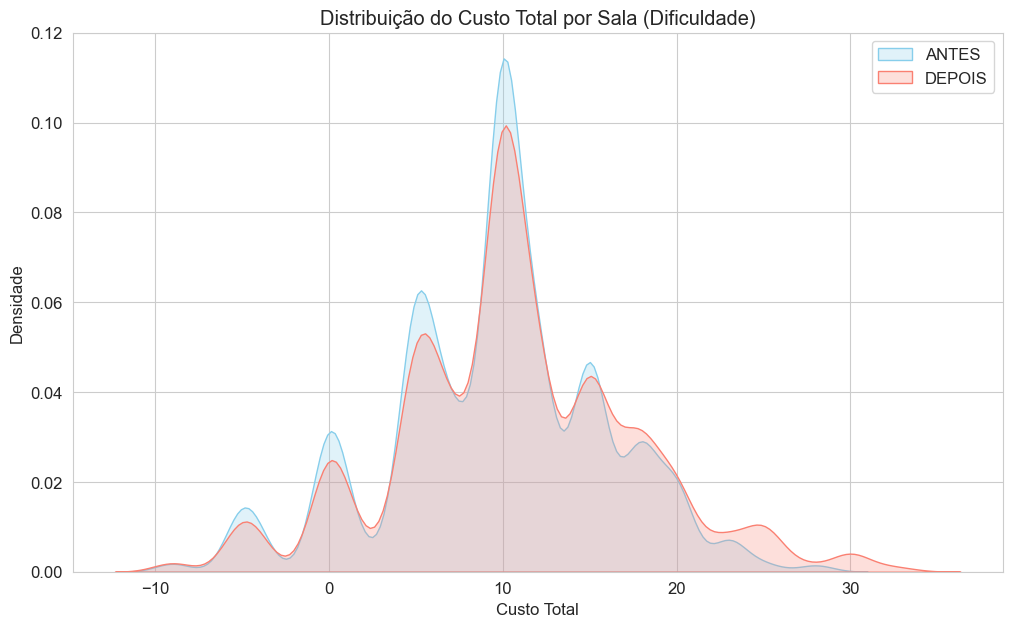

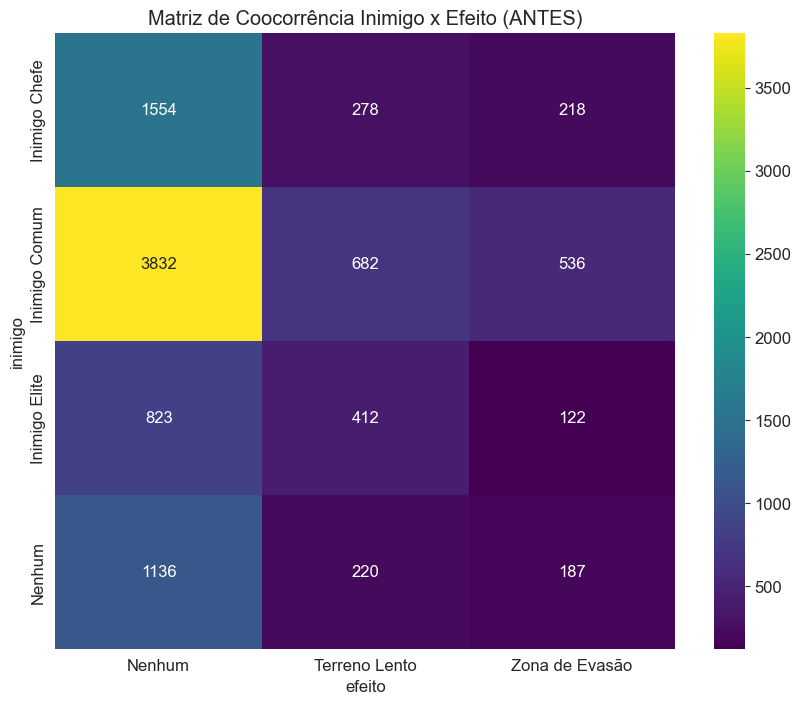

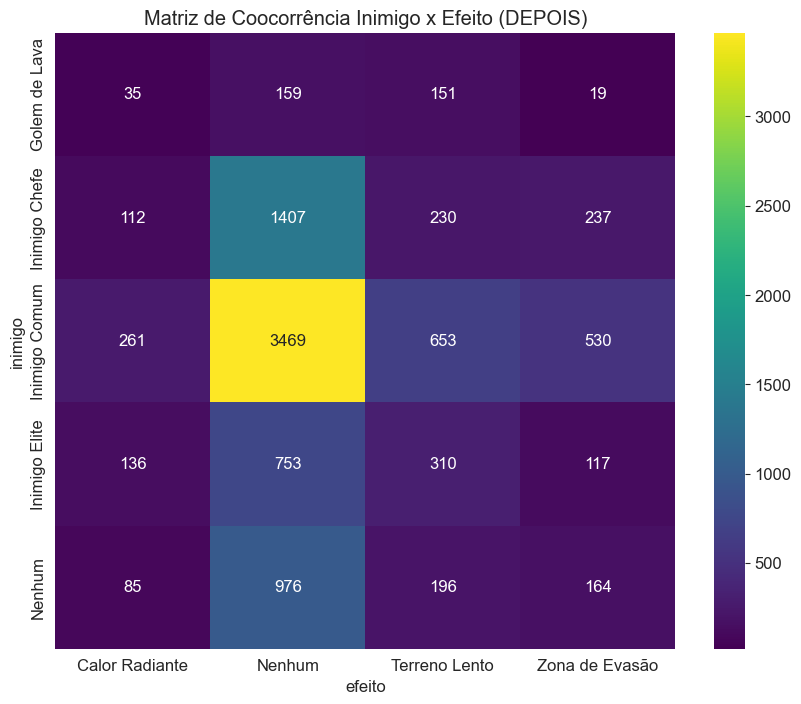



--- PAINEL DE CONTROLE DE IMPACTO ---

                      Métrica  Valor ANTES  Valor DEPOIS  Variação (%)
            Custo Médio Total       9.6475       10.6589       10.4835
         Entropia H(Inimigos)       1.7735        1.9259        8.5954
          Entropia H(Efeitos)       1.0928        1.3927       27.4419
Info Mútua I(Inimigo; Efeito)       0.0155        0.0236       52.7891


In [15]:
# Análise de Frequência para Inimigos e Efeitos
analisar_frequencia(df_antes, df_depois, 'inimigo')
analisar_frequencia(df_antes, df_depois, 'efeito')

# Análise de Custo Total
analisar_custo(df_antes, df_depois)

# Análise de Coocorrência
analisar_coocorrencia(df_antes, 'ANTES')
analisar_coocorrencia(df_depois, 'DEPOIS')

# CÉLULA 7: Cálculo e Apresentação do Resumo Quantitativo

metricas_antes = calcular_metricas_info(df_antes, 'inimigo', 'efeito')
metricas_depois = calcular_metricas_info(df_depois, 'inimigo', 'efeito')

resumo = pd.DataFrame({
    'Métrica': ['Custo Médio Total', 'Entropia H(Inimigos)', 'Entropia H(Efeitos)', 'Info Mútua I(Inimigo; Efeito)'],
    'Valor ANTES': [
        df_antes['custo_total'].mean(),
        metricas_antes['H(col1)'],
        metricas_antes['H(col2)'],
        metricas_antes['I(col1;col2)']
    ],
    'Valor DEPOIS': [
        df_depois['custo_total'].mean(),
        metricas_depois['H(col1)'],
        metricas_depois['H(col2)'],
        metricas_depois['I(col1;col2)']
    ]
})

resumo['Variação (%)'] = ((resumo['Valor DEPOIS'] / resumo['Valor ANTES']) - 1) * 100

print("\n\n--- PAINEL DE CONTROLE DE IMPACTO ---\n")
print(resumo.to_string(index=False, float_format="%.4f"))